In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from settings  import *
from preprocessing import *
import mne
import dataset as ds
from train import *
import decode as dec
from importlib import reload

from models import Relative_Positioning, StagerNet, Decoder
from dataset import Decoder_Dataset, DecoderSampler, SequentialSampler
import process
from train import load_losses, save_losses
from torch import nn, optim
import argparse 
reload(process)
reload(dec)
reload(ds)

<module 'dataset' from '/home/brain/EEG-ssl/dataset.py'>

In [3]:
# models params
C = 64
T =1000
M = 10
#training paramms
epochs = 20
batch_size = 40
lr = 1e-3
resume = False
#datasets params
n_train = 4000
n_test = 500
#sampling params
pos= 3000
neg = 7000

s_weights = [0.5, 1-0.5]


In [4]:
import torch
from torch.nn import *
from pylab import *
from torch import optim
from torch.utils import data
from torch import nn
from torch.nn.functional import soft_margin_loss

In [5]:
import contextlib
import io
import sys

class DummyFile(object):
    def write(self, x): pass

@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = DummyFile()
    yield
    sys.stdout = save_stdout


In [6]:
def _train_dec(model, train_loader, optimizer, epoch):
    
    model.train()
    train_losses = []
    batch_size = train_loader.batch_size
    for batch_x, batch_y in train_loader:
        #print(batch_y)
        #print('in')
        loss = torch.tensor([0.0], requires_grad=True)
        for x,y in zip(batch_x, batch_y):
            x = x.squeeze(dim= 0 )
            y = y.to(DEVICE)
            out = model(x)
            #print(out.shape)
            loss = loss+ model.loss_fn(out.unsqueeze(dim =0), y)
        loss =loss/batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return [mean(train_losses)]
def _eval_loss_dec(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in data_loader:
            x = x.squeeze(dim= 0 )
            y = y.to(DEVICE)
            loss = model.loss_fn(model(x).unsqueeze(dim = 0), y)
            total_loss += loss #* x[0].shape[0] #
        avg_loss = total_loss / data_loader.sampler.size# / len(data_loader.dataset)
    return avg_loss.item()

def _train_epochs_dec(model, train_loader, test_loader, train_args):
    
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if not os.path.exists(SAVED_MODEL_DIR):
        os.makedirs(SAVED_MODEL_DIR)

    train_losses = []
    test_losses = [_eval_loss_dec(model, test_loader)]
    for epoch in range(1, epochs+1):
        model.train()
        train_losses.extend(_train_dec(model, train_loader, optimizer, epoch))
        test_loss = _eval_loss_dec(model, test_loader)
        test_losses.append(test_loss)
        y_true, y_pred = get_test_results(model, test_loader)
        acc_score = accuracy_score(y_true, y_pred)
        print(f'Epoch {epoch}, Test loss {test_loss:.4f}, \tAccuracy: {100*acc_score:.2f}%')

        # save model every 10 epochs
        if epoch % 2 == 0:
            torch.save(model.state_dict(), os.path.join(ROOT, 'saved_models', 'decoder_epoch{}.pt'.format(epoch)))
    torch.save(model.state_dict(), os.path.join(ROOT, 'saved_models', 'decoder.pt'))
    return train_losses, test_losses



def train_decoder(model, train_dataset, val_dataset,samplers, n_epochs=20, lr=1e-3, batch_size=256, load_last_saved_model=False, num_workers=8):
	
	if load_last_saved_model:
		model.load_state_dict(torch.load(os.path.join(ROOT, SAVED_MODEL_DIR, 'decoder.pt')))
	if torch.cuda.device_count() > 1:
		model = nn.DataParallel(model)
	model.to(DEVICE)

	train_loader = train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size, num_workers=0,
                                          sampler = samplers["train"], collate_fn = collate)
	val_loader = val_loader = torch.utils.data.DataLoader(val_dataset, num_workers=0,
                                          sampler = samplers["val"])
	new_train_losses, new_test_losses = _train_epochs_dec(model, train_loader, val_loader, 
																				 dict(epochs=n_epochs, lr=lr))
	if load_last_saved_model:
		train_losses, test_losses = load_losses(SAVED_MODEL_DIR, 'decoder')
	else:
		train_losses = []
		test_losses = []
	train_losses.extend(new_train_losses)
	test_losses.extend(new_test_losses)
	save_losses(train_losses, test_losses, SAVED_MODEL_DIR, 'decoder')
	return train_losses, test_losses, model

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, EEG_FeatureExtractor, aggregator,  C, T, embedding_dim=100, hidden_dim= 20):
        super().__init__()
        self.feature_extractor = EEG_FeatureExtractor
        #self.feature_extractor.float()
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 12)
        self.aggr = aggregator
        self.loss_fn = nn.CrossEntropyLoss()
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        with torch.no_grad():
            x = self.feature_extractor(x)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        out = self.aggr(x, axis = 0)
        return out   
    

class AudioTransformer(nn.Module):
    """
     DETR implementation.

    
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        
        # create conversion layer
        self.conv = nn.Conv2d(1024, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes )
        #self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(1, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        
        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(inputs)
        #print(h.shape)
        # construct positional encodings
        H, W = h.shape[-2:]
        N = h.shape[0]
        #print(H,W)
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)
        #print(h.flatten(1).shape)
        #print(pos.shape)
        e = pos + 0.1 * h.flatten(2).permute(2, 0, 1)
        k = self.query_pos.unsqueeze(1).repeat(1,N,1)
        #print(k.size(1), e.size(1))
        #print(k.shape, e.shape)
        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1).repeat(1,N,1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return  torch.nn.Softmax(dim = 2)(self.linear_class(h) ) 

In [8]:
class Transcoder(nn.Module):
    
    def __init__(self,  C, T, nhead = 8, num_layers = 6,  hidden_dim= 20):
        super().__init__()
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=1000, nhead=nhead)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.query = nn.Parameter(torch.rand(64, 1000).unsqueeze(0))

        self.pooling = nn.AdaptiveMaxPool3d(output_size=( 10, 20))
        self.linear2 = nn.Linear(200, 12)
        self.flatten = nn.Flatten()
        self.loss_fn = nn.CrossEntropyLoss()
        self.relu = torch.nn.ReLU()
    def forward(self, x):
       
        x = self.transformer_decoder(x, self.query)
        print(x.shape)
        x = self.pooling(x)
        x = x.tanh()
        x = self.flatten()
        x = self.linear1(x)
    
        return out   

In [9]:
x = torch.rand(1,14, 64,1000).to(DEVICE)

In [10]:
cc = Transcoder(C,T, 2, 4)
cc.to(DEVICE).to(float)

Transcoder(
  (decoder_layer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): Linear(in_features=1000, out_features=1000, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): Linear(in_features=1000, out_features=1000, bias=True)
    )
    (linear1): Linear(in_features=1000, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=1000, bias=True)
    (norm1): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=False)
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear

In [12]:
cc(x.squeeze(0))

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #2 'mat2' in call to _th_mm

In [30]:
get_test_results(coder, val_loader)

ValueError: too many values to unpack (expected 3)

In [13]:
#import get_results as res
from sklearn.metrics import balanced_accuracy_score, accuracy_score
def get_test_results(model, test_loader):
    y_true = []
    y_pred = []
    model.eval()
    softmax = nn.Softmax(dim = 1)
    with torch.no_grad():
        
        for x, y in test_loader:
            
            x = x.to(DEVICE).to(float).contiguous().squeeze(dim= 0)
            y = y.to(DEVICE).to(float).contiguous()
            out = model(x)
            _, predicted = torch.max(softmax(out.unsqueeze(dim =0)), 1)
            y_true.extend(list(y.cpu().numpy()))
            y_pred.extend(list(predicted.cpu().numpy()))
    return y_true, y_pred

def decoder_scores(model, subjects, trials):
    
    test_dataset = Decoder_Dataset(subjects,trials, T, step = 512)
    test_sampler = SequentialSampler(test_dataset, batch_size = 168, weights = [1/12]*12, size = 168)
    test_loader = torch.utils.data.DataLoader(test_dataset, num_workers=0,
                                          sampler = test_sampler)
    y_true, y_pred = get_test_results(model, test_loader)
    acc_score = accuracy_score(y_true, y_pred)
    balanced_acc_score = balanced_accuracy_score(y_true, y_pred)
    print(f'Performance of the network on the test trials:')
    print(f'\tAccuracy: {100*acc_score:.2f}%')
    print(f'\tBalanced accuracy: {100*balanced_acc_score:.2f}%')
    return acc_score, balanced_acc_score

#decoder_scores(model_dec, subjects, [0,1,2])

In [14]:
ssl_model = Relative_Positioning(StagerNet,C , T, embedding_dim = M )
ssl_model.load_state_dict(torch.load(os.path.join(ROOT, 'saved_models', 'ssl_model.pt')))
model = ssl_model.feature_extractor
subjects = SUBJECTS[:-2]
    #split data
val_subjects = [SUBJECTS[-2]]
aggregator = torch.mean
decoder = dec.Decoder(model, aggregator, C, T, embedding_dim=M, hidden_dim = 20)
decoder.to(float).to(DEVICE)



Decoder(
  (feature_extractor): StagerNet(
    (relu): ReLU()
    (spatial_conv): Conv2d(1, 64, kernel_size=(64, 1), stride=(1, 1))
    (temp_conv1): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25))
    (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (temp_conv2): Conv2d(16, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25))
    (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxPool): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten()
    (dropout): Dropout(p=0.5, inplace=False)
    (linear_class): Linear(in_features=5120, out_features=10, bias=True)
  )
  (linear1): Linear(in_features=10, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=12, bias=True)
  (loss_fn): CrossEntropyLoss()
  (relu): ReLU()
)

In [15]:
train_dataset = Decoder_Dataset(subjects,[0,1,3,4], T, step = 512)
val_dataset = Decoder_Dataset(subjects,[2], T, step = 512)
train_sampler = DecoderSampler(train_dataset, batch_size = 50, weights = [1/12]*12, size = 400)
val_sampler = SequentialSampler(val_dataset, batch_size = 168, weights = [1/12]*12, size = 168)
samplers = {"train" : train_sampler, "val": val_sampler}
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = 50, num_workers=0,
                                          sampler = samplers["train"], collate_fn = collate)
val_loader = torch.utils.data.DataLoader(val_dataset, num_workers=0,
                                          sampler = samplers["val"])

#train_losses, test_losses, model_dec = train_decoder(decoder, train_dataset, val_dataset,samplers, n_epochs=30, lr=1e-4, 
             # batch_size=50, num_workers=0)

In [42]:
for x ,y in train_loader:
    print(1)
    break

1


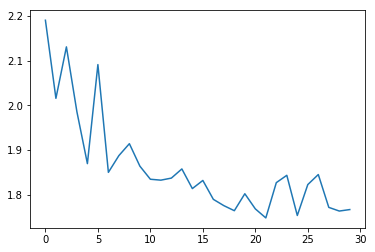

In [32]:
from pylab import *
#plot(test_losses)
plot(train_losses)

In [26]:
print(train_losses)

[2.1905952183895265, 2.015892108827999, 2.1310329382230258, 1.985882694335215, 1.869807677373881, 2.0913640778798404, 1.8503065948773267, 1.8877538291063125, 1.91443641541185, 1.8642055634985335, 1.834878183546482, 1.8328302411881279, 1.8374393558184703, 1.8579446916635585, 1.813999224414247, 1.832174593801553, 1.7899169059446847, 1.7758304707768202, 1.7645058642879994, 1.802437238128288, 1.768574142407999, 1.748361498254433, 1.8272818627015033, 1.843679213261173, 1.7538028258403309, 1.8229466771288576, 1.845396094127975, 1.7719376356773455, 1.7637339035084334, 1.7670536966426296]


In [27]:
epoch , test_loss, acc_score = 1,8, 9
print(f'Epoch {epoch}, Test loss {test_loss:.4f}, Accuracy: {100*acc_score:.2f}%')

Epoch 1, Test loss 8.0000, Accuracy: 900.00%


In [28]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
acc_score = accuracy_score(y_true, y_pred)
balanced_acc_score = balanced_accuracy_score(y_true, y_pred)
print(acc_score,balanced_acc_score )

NameError: name 'y_true' is not defined

In [ ]:
def main(model_name : str, data : List[torch.tensor], epochs : int, C : int, T : int, M : int, batch_size : int, n_train : int, 
         n_test: int , s_weights : List[float], pos : int, neg : int, lr : float = 1e-3 ):
    #define ssl model
    X_train = data[0]
    X_test = data[1]
    ssl_model = Relative_Positioning(StagerNet,C , T, embedding_dim = M )
    ssl_model.to(float)
    # datasets
    train_dataset =  RP_Dataset(X_train, sampling_params = (pos, neg), temp_len = T ,
                                n_features = C )
    test_dataset =  RP_Dataset(X_test, sampling_params = (pos, neg), temp_len = T ,
                                n_features = C )

    train_sampler = WeightedSampler(train_dataset, batch_size = batch_size ,size = n_train,  
                              weights = s_weights)
    test_sampler = WeightedSampler(test_dataset, batch_size = batch_size ,size = n_test,  
                              weights = s_weights)
    samplers = {"train" : train_sampler, "val": test_sampler}


    #train ssl 
    train_losses, test_losses, model = train_ssl(ssl_model, train_dataset, test_dataset,
                                                 samplers,n_epochs=epochs, lr=lr,batch_size= batch_size, 
                                                 load_last_saved_model=False, num_workers= 0)

    return train_losses, test_losses, model
